In [31]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from sklearn.datasets import fetch_openml

%matplotlib inline 

In [2]:
ames_housing = fetch_openml(name="house_prices", as_frame = True)
ames_df = ames_housing.data
print(ames_df.shape)
ames_df.head()

(1460, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal


In [3]:
Xy = (
    ames_df
    .assign(SalePrice = ames_housing.target) # add target feature
    .set_index('Id')
    .loc[lambda df: df['MasVnrType'].notna()] # drop outliers with missing detail in this column
    .loc[lambda df: df['Electrical'].notna()] # drop outlier with missing electrical row
    .assign(
        AgeAtSale = lambda df: df['YrSold'].sub(df['YearBuilt']), # add interpretable year columns
        YearsSinceRemodel = lambda df: df['YrSold'].sub(df['YearRemodAdd']).clip(lower = 0), # clip lower for outlier
        HasDeck = lambda df: df['WoodDeckSF'].gt(0).map(int),
        HasPorch = lambda df: df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].gt(0).max(axis = 1).map(int),
        HasFireplace = lambda df: df['Fireplaces'].clip(upper = 1).map(int),
        HasFence = lambda df: df['Fence'].notna().map(int)
    )

    # drop year columns
    .drop(
        columns = [
            'GarageYrBlt', 'YearBuilt', 'YrSold', 'YearRemodAdd',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'FireplaceQu', 'Fireplaces',
            'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea'
        ]
    )
    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(0)) # fill missing with 0
    .fillna('NA') # rest of missing values are in categorical columns, so fill with NA category
    .assign(Intercept = 1) # add constant column for OLS
)

Xy

,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,SalePrice,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,HasFireplace,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1.0,60.0,RL,65.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,208500.0,5.0,5.0,0,1,0,0,1
2.0,20.0,RL,80.0,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,181500.0,31.0,31.0,1,0,1,0,1
3.0,60.0,RL,68.0,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,223500.0,7.0,6.0,0,1,1,0,1
4.0,70.0,RL,60.0,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,140000.0,91.0,36.0,0,1,1,0,1
5.0,60.0,RL,84.0,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,250000.0,8.0,8.0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456.0,60.0,RL,62.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,175000.0,8.0,7.0,0,1,1,0,1
1457.0,20.0,RL,85.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,210000.0,32.0,22.0,1,0,1,1,1
1458.0,70.0,RL,66.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,266500.0,69.0,4.0,0,1,1,1,1


In [4]:
# identify categorical columns for one hot encoding
categorical = list(Xy.apply(lambda series: series.dtype).loc[lambda df: df.eq('object')].index) + ['MSSubClass']
X = Xy.drop(columns='SalePrice')
X_ohe = X.pipe(pd.get_dummies, prefix_sep = '_OHE_', columns=categorical)
y = Xy['SalePrice']

In [5]:
model = sm.OLS(y, X_ohe)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     59.41
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:39:56   Log-Likelihood:                -16565.
No. Observations:                1451   AIC:                         3.362e+04
Df Residuals:                    1206   BIC:                         3.491e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage                   9.1690     24.385      0.376      0.707     -38.674      57.012
OverallQual                6443.4507   1098.337      5.867      0.000    4288.587    8598.315
OverallCond                5761.3467    921.305      6.253      0.000    3953.808    7568.885
GrLivArea                    71.2724      3.926     18.155      0.000      63.570      78.975
BsmtFullBath               7808.0939   1862.581      4.192      0.000    4153.836    1.15e+04
BsmtHalfBath               2704.3964   3161.287      0.855      0.392   -3497.837    8906.630
FullBath                   4353.2284   2358.076      1.846      0.065    -273.159    8979.616
HalfBath                   1125.2313   2213.287      0.508      0.611   -3217.089    5467.552
BedroomAbvGr              -4678.0376   1473.399     -3.175      0.002   -7568.747   -1787.328
KitchenAbvGr              -1.089e+04   6648.976     -1.639      0.102   -2.39e+04    2150.473
TotRmsAbvGrd               1013.7051   1016.102      0.998      0.319    -979.818    3007.228
GarageCars                 8663.3405   1708.010      5.072      0.000    5312.340     1.2e+04
MiscVal                       9.0392      6.684      1.352      0.177      -4.074      22.153
MoSold                     -510.0946    260.244     -1.960      0.050   -1020.675       0.486
AgeAtSale                  -305.4555     85.143     -3.588      0.000    -472.501    -138.410
YearsSinceRemodel           -27.7465     58.392     -0.475      0.635    -142.308      86.815
HasDeck                    1621.8650   1585.671      1.023      0.307   -1489.115    4732.845
HasPorch                   1870.3246   1739.962      1.075      0.283   -1543.365    5284.014
HasFireplace               2375.0085   1818.079      1.306      0.192   -1191.941    5941.958
HasFence                  -5877.2263   2031.768     -2.893      0.004   -9863.419   -1891.033
Intercept                 -8887.1036   3683.133     -2.413      0.016   -1.61e+04   -1661.044
MSZoning_OHE_C (all)      -2.978e+04   8731.959     -3.411      0.001   -4.69e+04   -1.27e+04
MSZoning_OHE_FV            1.271e+04   6497.547      1.957      0.051     -33.757    2.55e+04
MSZoning_OHE_RH            4234.7895   6421.424      0.659      0.510   -8363.614    1.68e+04
MSZoning_OHE_RL            4630.5784   3487.791      1.328      0.185   -2212.233    1.15e+04
MSZoning_OHE_RM            -682.4301   3937.317     -0.173      0.862   -8407.183    7042.323
Street_OHE_Grvl           -8776.6589   6992.025     -1.255      0.210   -2.25e+04    4941.225
Street_OHE_Pave            -110.4448   6575.318     -0.017      0.987    -1.3e+04    1.28e+04
Alley_OHE_Grvl            -1810.1857   3604.374     -0.502      0.616   -8881.726    5261.355
Alley_OHE_NA              -4693.0936   2616.409     -1.794      0.073   -98

In [6]:
from sklearn.model_selection import train_test_split
x_train_ohe, x_test_ohe, x_train, x_test, y_train, y_test = train_test_split(X_ohe, X, y, test_size=0.2, random_state=0)

In [7]:
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1)
search.fit(x_train_ohe, y_train)
print("Best estimator: ", search.best_params_)
print("Test set score: ", search.best_estimator_.score(x_test_ohe, y_test))

Best estimator:  {'learning_rate': 0.1, 'max_depth': 5}
Test set score:  0.8581588030286735


# Correlation Interpretation

In [8]:
fitted_model = search.best_estimator_
background = shap.maskers.Independent(x_train_ohe, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=X_ohe.columns
)
shap_values = explainer(x_test_ohe)

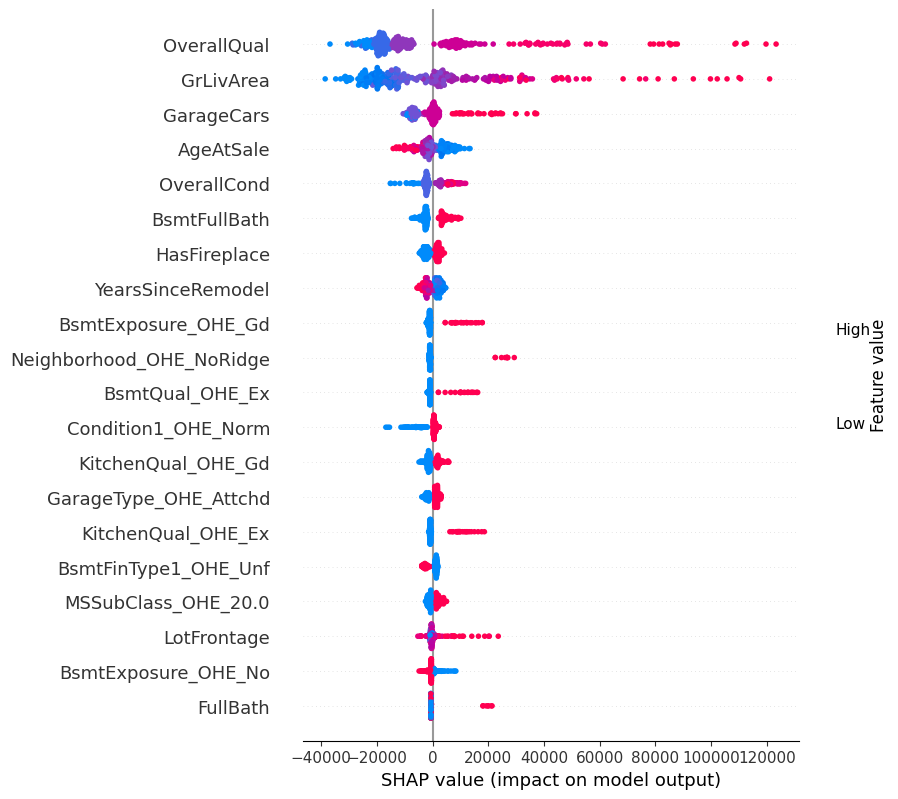

In [9]:
# plot the feature importance
shap.summary_plot(shap_values, x_test_ohe)

# Causal Interpretation

In [10]:
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(shap_values.feature_names, vals)), columns=["features", "importance"])
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

# keep top k features for causal analysis
k = 5
sorted_features = feature_importance["features"]
top_k_features = list(sorted_features.values)[:5]

In [11]:
top_k_features

['OverallQual', 'GrLivArea', 'GarageCars', 'AgeAtSale', 'OverallCond']

In [12]:
from econml.solutions.causal_analysis import CausalAnalysis

# initialize heterogeneity features
hetero_cols = ['AgeAtSale', 'MSZoning']
ca = CausalAnalysis(
    feature_inds=top_k_features + ['HasFireplace', 'HasPorch', 'HasDeck'],
    categorical=categorical + ['HasFireplace', 'HasPorch', 'HasDeck', 'HasFence'],
    heterogeneity_inds=hetero_cols,
    classification=False,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
    upper_bound_on_cat_expansion=6
)
ca.fit(x_train, y_train)

In [13]:
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverallQual,num,10103.815563,1675.148678,6.031593,1.623509e-09,6820.584485,13387.046640
GarageCars,num,13144.175268,2997.638920,4.384843,1.160696e-05,7268.910946,19019.439590
OverallCond,num,5645.799133,1457.913311,3.872520,1.077156e-04,2788.341551,8503.256716
GrLivArea,num,53.680237,16.896738,3.176959,1.488283e-03,20.563239,86.797235
HasFireplace,1v0,4391.217178,1510.683165,2.906776,3.651749e-03,1430.332582,7352.101775
HasPorch,1v0,4702.903044,2279.139024,2.063456,3.906933e-02,235.872642,9169.933446
AgeAtSale,num,-122.702114,110.966856,-1.105755,2.688327e-01,-340.193155,94.788926
HasDeck,1v0,1610.641783,1819.477098,0.885222,3.760367e-01,-1955.467800,5176.751367


In [14]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

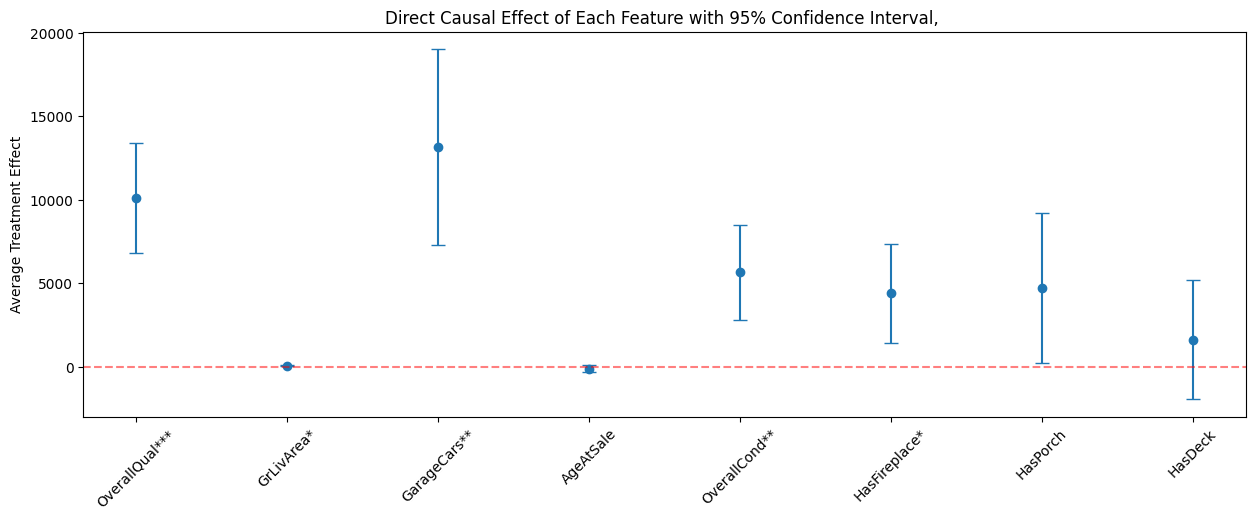

In [35]:
errorbar(global_summ)

# Segmentation -- How do different type of houses respond differently to having a fireplace?

In [18]:
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    x_test,
    "HasFireplace",
    max_depth=2,
    min_impurity_decrease=1e-6,
    min_samples_leaf = 5
)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


# Policy Analysis

In [19]:
plt.figure(figsize=(12, 8))
ca.plot_policy_tree(
    x_test,
    "HasFireplace",
    treatment_costs=2500,
    max_depth=2,
    min_samples_leaf = 5
)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [20]:
ca.individualized_policy(
    x_test,
    "HasFireplace",
    n_rows=5,
    treatment_costs=2500,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,...,MoSold,SaleType,SaleCondition,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,Current treatment,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1350.0,1,12224.503178,3758.862937,20690.143420,70.0,RM,50.0,Pave,Pave,Reg,...,12.0,WD,Normal,136.0,21.0,0,1,0,0,1
1063.0,1,9574.109709,3261.378628,15886.840790,190.0,RM,85.0,Pave,Grvl,Reg,...,9.0,WD,Normal,107.0,57.0,0,1,0,0,1
243.0,1,9482.716831,3235.816161,15729.617501,50.0,RM,63.0,Pave,NA,Reg,...,4.0,WD,Normal,106.0,56.0,0,1,0,0,1
199.0,1,8660.180927,2968.655603,14351.706250,75.0,RM,92.0,Pave,NA,Reg,...,7.0,WD,Abnorml,97.0,59.0,0,1,0,1,1
521.0,1,8618.608621,1186.794764,16050.422479,190.0,RL,60.0,Pave,Grvl,Reg,...,8.0,WD,Normal,108.0,8.0,1,1,0,0,1


# What If Analysis - How does the overall housing price change if every home had a fireplace?

In [21]:
whatif_df = (
    x_test
    .loc[
        lambda df: df['HasFireplace'].eq(0)
    ]
)
whatif_y = y_test.loc[whatif_df.index]

cf = ca.whatif(whatif_df, whatif_df['HasFireplace'].add(1).clip(upper = 1), 'HasFireplace', whatif_y)
print("Current average housing price on test set: ", whatif_y.mean())
print("Average housing price with one more room on test set: ", cf["point_estimate"].mean())

Current average housing price on test set:  142705.43537414967
Average housing price with one more room on test set:  147392.03061904764


In [22]:
# distribution comparison
plt.hist(cf.point_estimate, label="With fireplace", alpha=0.7, weights=np.ones(len(whatif_y)) / len(whatif_y))
plt.hist(whatif_y, label="Without fireplace", alpha=0.7, weights=np.ones(len(whatif_y)) / len(whatif_y))
plt.legend()
plt.xlabel("Housing Price")
plt.title("Histogram of Housing price -- Current vs. One more room")

Text(0.5, 1.0, 'Histogram of Housing price -- Current vs. One more room')

# Cohort Analysis -- What is the causal effect on a new dataset?

In [23]:
ca.cohort_causal_effect(x_test)

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverallQual,num,10207.265524,1694.108274,6.025155,1.689473e-09,6886.874322,13527.656727
GrLivArea,num,53.572155,16.896406,3.170624,1.521117e-03,20.455808,86.688502
GarageCars,num,13215.235723,3030.831642,4.360267,1.299037e-05,7274.914862,19155.556584
AgeAtSale,num,-139.794231,110.416091,-1.266068,2.054889e-01,-356.205793,76.617332
OverallCond,num,5723.914340,1462.849911,3.912851,9.121266e-05,2856.781200,8591.047479
HasFireplace,1v0,4390.835030,1523.103093,2.882822,3.941301e-03,1405.607823,7376.062237
HasPorch,1v0,4713.175859,2303.096997,2.046451,4.071199e-02,199.188692,9227.163026
HasDeck,1v0,1653.390857,1836.856976,0.900120,3.680566e-01,-1946.782662,5253.564375


In [24]:
ca.local_causal_effect(x_test)

point       stderr     zstat  \
sample feature      feature_value                                        
0      OverallQual  num            10466.451123  1701.632579  6.150829   
       GrLivArea    num               54.152219     8.332353  6.499031   
       GarageCars   num            10319.768990  2381.310682  4.333651   
       AgeAtSale    num             -276.854177   115.013736 -2.407140   
       OverallCond  num             8238.320947  1069.053989  7.706179   
...                                         ...          ...       ...   
290    AgeAtSale    num             -276.854177   115.013736 -2.407140   
       OverallCond  num             5849.940818  3055.390550  1.914629   
       HasFireplace 1v0             1339.570649  2653.292705  0.504871   
       HasPorch     1v0             6906.589930  5156.130035  1.339491   
       HasDeck      1v0             1899.860305  3984.727566  0.476785   

                                        p_value     ci_lower      ci_upper  
sample feature      feature_value                                           
0      OverallQual  num            7.707896e-10  7131.312552  13801.589694  
       GrLivArea    num            8.083900e-11    37.821108     70.483330  
       GarageCars   num            1.466567e-05  5652.485818  14987.052162  
       AgeAtSale    num            1.607800e-02  -502.276958    -51.431396  
       OverallCond  num            1.296412e-14  6143.013632  10333.628263  
...                                         ...          ...           ...  
290    AgeAtSale    num            1.607800e-02  -502.276958    -51.431396  
       OverallCond  num            5.553977e-02  -138.514619  11838.396255  
       HasFireplace 1v0            6.136494e-01 -3860.787493   6539.928791  
       HasPorch     1v0            1.804109e-01 -3199.239237  17012.419098  
       HasDeck      1v0            6.335149e-01 -5910.062213   9709.782822  

[2328 rows x 6 columns]